# Object Recognition on CIFAR-10 Dataset

In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

import pylab

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Read data

In [ ]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [ ]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):
    model = tf.keras.Sequential()
    # Input layer: 32x32x3
    model.add(layers.Input(shape=(3072, )))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,)))
    # Convolution layer C1
    model.add(layers.Conv2D(num_ch_c1, kernel_size=9, padding='valid', activation='relu', use_bias=True, input_shape=(None, None, 3)))
    # Max pooling layer S1
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    # Convolution layer C2
    model.add(layers.Conv2D(num_ch_c2, kernel_size=5, padding='valid', activation='relu', use_bias=True))
    # Max pooling layer S2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    # Flattern before fully-connected layers
    model.add(layers.Flatten())
    # Dropout layer 1
    if use_dropout:
        model.add(layers.Dropout(rate = 0.5))
    # Fully-connected layer F3
    model.add(layers.Dense(300, activation = None))
    # Dropout layer 2
    if use_dropout:
        model.add(layers.Dropout(rate = 0.5))
    # Fully-connected layer F4
    model.add(layers.Dense(10, use_bias=True, input_shape=(300,)))  # Here no softmax because we have combined it with the loss
    print(model.summary())
    return model

In [ ]:
def main():
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    '''Question 2'''
    num_ch_c1 = 90  #10 30 50 70 90
    num_ch_c2 = 100  #20 40 60 80 100 

    epochs = 1000  
    batch_size = 128  
    learning_rate = 0.001
    
    '''Question 3'''
    optimizer_ = 'SGD' #'Adam' #'RMSProp' #'SGD-momentum' '  
    use_dropout = True # False   

    model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.1)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)

    # Training
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))

    # Creates a model that will return the outputs for conv and pooling layers
    layer_outputs = [layer.output for layer in model.layers[1:5]] 
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

    # Names of the layers as title
    layer_names = []
    for layer in model.layers[1:5]:
        layer_names.append(layer.name) 
    images_per_row = 10
    
    for i in range(2):
        # Test image
        plt.imshow(x_test[i, :].reshape(3,32,32).transpose(1,2,0))
        plt.show()
        
        # Returns a list of 4 Numpy arrays: one array per layer activation
        activations = activation_model.predict(x_test[i].reshape(1, 3072)) 
      
        for layer_name, layer_activation in zip(layer_names, activations): 
            # Number of features in the feature map
            n_features = layer_activation.shape[-1] 
            #The feature map has shape (1, size, size, n_features).
            size = layer_activation.shape[1] 
            # Tiles the activation channels in this matrix
            n_cols = n_features // images_per_row 
            display_grid = np.zeros((size * n_cols, images_per_row * size))
            for col in range(n_cols): 
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                    :, :,
                                                    col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    if channel_image.std() != 0:
                        channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, # Displays the grid
                                row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='gray')#cmap='viridis'
            plt.show()
            #plt.clf()

    # Create folder to store models and results
    if not os.path.exists('./models'):
        os.mkdir('./models')
    if not os.path.exists('./results'):
        os.mkdir('./results')

    # Save model
    if use_dropout:
        model.save(f'./models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
    else:
        model.save(f'./models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')

    
    # Save the plot for losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    if use_dropout:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf'
        )
    plt.close()

    # Save the plot for accuracies
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    if use_dropout:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'./results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf'
        )
    plt.close()
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 90)        21960     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 90)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 100)         225100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               4

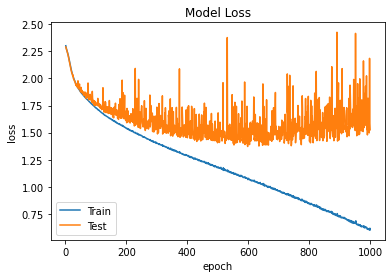

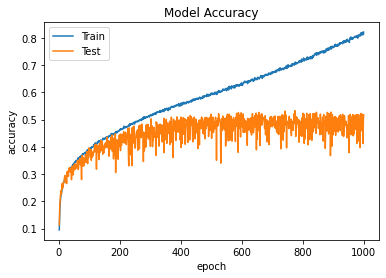

In [ ]:
if __name__ == '__main__':
    main()